In [1]:
import json

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='reddit_scraper.log', level=logging.DEBUG)
logger.info('Started')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/noah/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
class RateLimiter:
    def __init__(self, frequency):
        self.frequency = frequency
        self.last_time = None
    def get(self, url:str) -> requests.models.Response:
        if self.last_time is not None:
            t = self.frequency - (time.time() - self.last_time)
            logger.debug(f"RateLimiter sleeping for {t*1000} ms")
            time.sleep(t)
        response = requests.get(url)
        logger.info(f'Request to {url} returned {response.status_code}')
        self.last_time = time.time()
        return response

In [3]:
def get_load_url(soup):
    fpps = soup.find_all('faceplate-partial')
    for fpp in fpps:
        a = fpp.attrs
        try:
            if 'partial-more-posts' in a['id']:
                return fpp.attrs['src']
        except KeyError:
            pass
    raise Exception('No loader found!')

def get_content(link:str, r:RateLimiter) -> str:
    page = r.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    content = soup.find('div', class_='text-neutral-content')
    if content is None:
        return ''
    return content.text.strip()

def extract_data(entry, r:RateLimiter):
    a = entry.attrs
    link = a['content-href']
    logger.info(f'Extracting post {a['post-title']}')
    d =  {'meta': {
                'idx': int(a['feedindex']),
                'title': a['post-title'],
                'link': link,
                'votes': int(a['score']),
                'comments_count': int(a['comment-count']),
                'created': a['created-timestamp']
                },
            'body': get_content(link, r)}
    logger.debug(json.dumps(d, indent=2))
    return d

def get_posts(sub: str, calls: int = 1):
    url = f'https://www.reddit.com/r/{sub}/?feedViewType=compactView'
    r = RateLimiter(1)
    print(f'making request 1/{calls}')
    page = r.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    posts = soup.find_all('shreddit-post')
    logger.info(f'found {len(posts)} posts')
    out = []
    for post in tqdm(posts, desc='extracting posts', leave=False, unit='post'):
        out.append(extract_data(post, r))
    for i in range(1, calls):
        print(f'making request {i+1}/{calls}')
        l = get_load_url(soup)
        page = r.get(f'https://www.reddit.com{l}')
        soup = BeautifulSoup(page.content, 'html.parser')
        posts = soup.find_all('shreddit-post')
        for post in tqdm(posts, desc='extracting posts', leave=False, unit='post'):
            out.append(extract_data(post, r))
    return out

In [4]:
# Set RECOVER to True if you already have scraped data from here as CSV
# Set RECOVER to False if you want to scrape new data

RECOVER = False
if RECOVER:
    with open('r-autism.json', 'r') as f:
        data = json.load(f)
else:
    data = get_posts('autism', 10)
    out_file = 'r-autism.json'
    with open(out_file, 'w') as f:
        json.dump(data, f, indent=4)
    # df.to_csv('r-autism.csv', index=False)
print(json.dumps(data, indent=4))

making request 1/10


making request 2/10


making request 3/10


making request 4/10


making request 5/10


making request 6/10


making request 7/10


making request 8/10


making request 9/10


making request 10/10


[
    {
        "meta": {
            "idx": 0,
            "title": "Let\u2019s talk about ABA therapy. ABA posts outside this thread will be removed.",
            "link": "https://www.reddit.com/r/autism/comments/ub3skp/lets_talk_about_aba_therapy_aba_posts_outside/",
            "votes": 1939,
            "comments_count": 4526,
            "created": "2022-04-24T20:40:56.673000+0000"
        },
        "body": "ABA (Applied Behavior Analysis) therapy is one of our most commonly discussed topics here, and one of the most emotionally charged. In an effort to declutter the sub and reduce rule-breaking posts, this will serve as the master thread for ABA discussion.\n  \n    This is the place for asking questions, sharing personal experiences, linking to blog posts or scientific articles, and posting opinions. If you\u2019re a parent seeking alternatives to ABA, please give us a little information about your child. Their age and what goals you have for them are usually enough.\n  \n   

In [5]:
df = pd.json_normalize(data)
df

,body,meta.idx,meta.title,meta.link,meta.votes,meta.comments_count,meta.created
0,ABA (Applied Behavior Analysis) therapy is one...,0,Let’s talk about ABA therapy. ABA posts outsid...,https://www.reddit.com/r/autism/comments/ub3sk...,1939,4526,2022-04-24T20:40:56.673000+0000
1,This post is for any user who wants to share a...,1,Media Monday! Let's talk,https://www.reddit.com/r/autism/comments/1d1ln...,7,6,2024-05-27T07:01:09.573000+0000
2,"Doesn't have to be a bad smell, but not the no...",2,"What is a smell that isn't considered ""good"" t...",https://www.reddit.com/r/autism/comments/1d3vy...,85,151,2024-05-30T04:46:11.731000+0000
3,"Basically, what is a food that you won't eat s...",3,What is your food ick?,https://www.reddit.com/r/autism/comments/1d3ox...,220,346,2024-05-29T22:44:11.396000+0000
4,How are you guys?\n \n\n\n\n Read more,4,Hello everyone. Just checking on you,https://www.reddit.com/r/autism/comments/1d3rq...,91,113,2024-05-30T00:59:46.932000+0000
...,...,...,...,...,...,...,...
230,"I've managed to stay in mainstream education, ...",230,Websites to search for autism friendly jobs/co...,https://www.reddit.com/r/autism/comments/1d3ap...,3,1,2024-05-29T12:12:20.472000+0000
231,I started taking lexapro for depression and an...,231,Anyone allowed to stay on lexapro and amytript...,https://www.reddit.com/r/autism/comments/1d3ip...,1,1,2024-05-29T18:07:55.064000+0000
232,"So, my son hates all of it - wipes, microfiber...",232,What should I buy to wipe my son's mouth and h...,https://www.reddit.com/r/autism/comments/1d3im...,2,18,2024-05-29T18:03:59.394000+0000
233,there's rarely anything good ive ever experien...,233,Sensory sensitivity - EVERYTHING HURTS and I H...,https://www.reddit.com/r/autism/comments/1d38u...,4,3,2024-05-29T10:22:57.694000+0000


In [6]:
sia = SentimentIntensityAnalyzer()

df['title_sentiment'] = df['meta.title'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['content_sentiment'] = df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])
df

,body,meta.idx,meta.title,meta.link,meta.votes,meta.comments_count,meta.created,title_sentiment,content_sentiment
0,ABA (Applied Behavior Analysis) therapy is one...,0,Let’s talk about ABA therapy. ABA posts outsid...,https://www.reddit.com/r/autism/comments/ub3sk...,1939,4526,2022-04-24T20:40:56.673000+0000,0.0000,0.7228
1,This post is for any user who wants to share a...,1,Media Monday! Let's talk,https://www.reddit.com/r/autism/comments/1d1ln...,7,6,2024-05-27T07:01:09.573000+0000,0.0000,0.8668
2,"Doesn't have to be a bad smell, but not the no...",2,"What is a smell that isn't considered ""good"" t...",https://www.reddit.com/r/autism/comments/1d3vy...,85,151,2024-05-30T04:46:11.731000+0000,0.6369,0.8020
3,"Basically, what is a food that you won't eat s...",3,What is your food ick?,https://www.reddit.com/r/autism/comments/1d3ox...,220,346,2024-05-29T22:44:11.396000+0000,0.0000,-0.9010
4,How are you guys?\n \n\n\n\n Read more,4,Hello everyone. Just checking on you,https://www.reddit.com/r/autism/comments/1d3rq...,91,113,2024-05-30T00:59:46.932000+0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...
230,"I've managed to stay in mainstream education, ...",230,Websites to search for autism friendly jobs/co...,https://www.reddit.com/r/autism/comments/1d3ap...,3,1,2024-05-29T12:12:20.472000+0000,0.4939,0.9666
231,I started taking lexapro for depression and an...,231,Anyone allowed to stay on lexapro and amytript...,https://www.reddit.com/r/autism/comments/1d3ip...,1,1,2024-05-29T18:07:55.064000+0000,0.0000,-0.9743
232,"So, my son hates all of it - wipes, microfiber...",232,What should I buy to wipe my son's mouth and h...,https://www.reddit.com/r/autism/comments/1d3im...,2,18,2024-05-29T18:03:59.394000+0000,-0.4404,-0.8094
233,there's rarely anything good ive ever experien...,233,Sensory sensitivity - EVERYTHING HURTS and I H...,https://www.reddit.com/r/autism/comments/1d38u...,4,3,2024-05-29T10:22:57.694000+0000,-0.8506,-0.7383


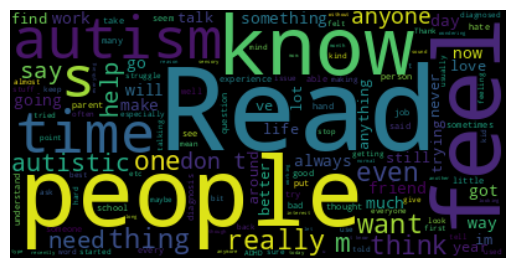

In [7]:
wc = WordCloud(stopwords=STOPWORDS).generate(' '.join(df['body']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

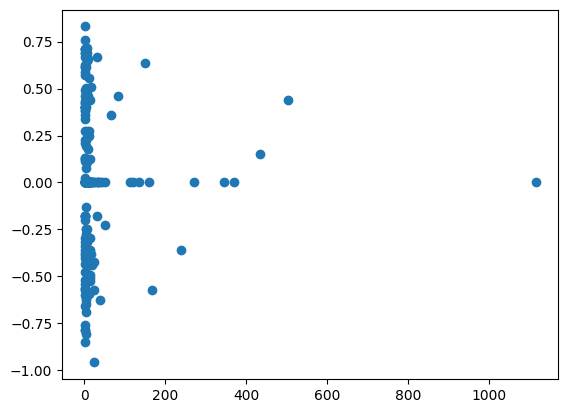

In [8]:
plt.scatter(df[1:]['meta.comments_count'], df[1:]['title_sentiment'])
plt.show()